# RL Pricing Notebook (Model-Based, Multi-Step) for `autos.csv`

This notebook builds a model-based reinforcement learning pipeline for pricing used-car listings when true repricing trajectories are unavailable.  
We model listing disappearance as a weekly hazard process and train a tabular Q-learning policy in that simulated environment.

## Cell 0 — Config + Imports

In [1]:
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error

np.random.seed(42)
random.seed(42)

# ============================================================================
# DATA & ENVIRONMENT CONFIGURATION
# ============================================================================
DATA_PATH = "data/autos.csv"
CURRENT_YEAR = 2025
TMAX = 12  # Maximum weeks to track a listing

# ============================================================================
# GERMAN-TO-ENGLISH TRANSLATION MAPPING
# ============================================================================
GERMAN_TRANSLATIONS = {
    'gearbox': {
        'Manuell': 'Manual',
        'Automatik': 'Automatic'
    },
    'fuelType': {
        'Diesel': 'Diesel',
        'Benzin': 'Petrol',
        'Hybrid': 'Hybrid',
        'LPG': 'LPG',
        'Elektro': 'Electric'
    },
    'vehicleType': {
        'Limousine': 'Sedan',
        'SUV': 'SUV',
        'Kombi': 'Estate',
        'Coupe': 'Coupe',
        'Cabrio': 'Convertible',
        'Transporter': 'Van',
        'Kleinwagen': 'City Car',
        'Geländewagen': 'Off-road',
        'Pickup': 'Pickup'
    },
    'seller': {
        'privat': 'private',
        'gewerblich': 'dealer'
    }
}

# ============================================================================
# PRICING ACTIONS
# ============================================================================
ACTION_PCTS = np.array([-0.05, -0.03, 0.0, +0.03, +0.05], dtype=float)

# ============================================================================
# RL TRAINING HYPERPARAMETERS
# ============================================================================
ALPHA = 0.10  # Learning rate
GAMMA = 0.98  # Discount factor
HOLDING_COST = 40.0  
N_EPISODES = 10000  
N_EVAL = 1000

# ============================================================================
# EXPLORATION STRATEGY (Epsilon-Greedy)
# ============================================================================
EPS_START = 1.0  # Initial exploration rate (100% random actions)
EPS_END = 0.05  # Final exploration rate (5% random actions)
EPS_DECAY = 0.995  # Decay multiplier applied each episode

# ============================================================================
# STATE DISCRETIZATION
# ============================================================================
# Price deviation delta is binned into 16 intervals across [-0.5, 0.5]
DELTA_BINS = np.linspace(-0.5, 0.5, 16)

# ============================================================================
# DATA FILTERING
# ============================================================================
MIN_MODEL_COUNT = 200  # Minimum listings per brand-model to retain

# ============================================================================
# LIGHTGBM PRICE MODEL HYPERPARAMETERS
# ============================================================================
PRICE_MODEL_PARAMS = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "num_leaves": 64,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
}

## 1) Load + Clean Data (lightweight)

In [2]:
df = pd.read_csv(DATA_PATH, encoding='latin-1')

for dt_col in ["dateCreated", "lastSeen", "dateCrawled"]:
    if dt_col in df.columns:
        df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")

df = df.dropna(subset=["dateCreated", "lastSeen"]).copy()
df["duration_days"] = (df["lastSeen"] - df["dateCreated"]).dt.total_seconds() / 86400.0
df = df[df["duration_days"] >= 0].copy()

In [3]:
# Build ad_id from (brand, model, year, km, gearbox, color, seller)
# This identifies the same car listed multiple times with potentially different prices

if "color" not in df.columns:
    df["color"] = "unknown"
df["color"] = df["color"].fillna("unknown").astype(str)

# Create composite key to identify unique ads
df["ad_id"] = (
    df["brand"].astype(str) + "|" +
    df["model"].astype(str) + "|" +
    df["yearOfRegistration"].astype(int).astype(str) + "|" +
    df["kilometer"].astype(int).astype(str) + "|" +
    df["gearbox"].astype(str) + "|" +
    df["color"].astype(str) + "|" +
    df["seller"].astype(str)
)

# Count how many ads have multiple observations (price trajectories)
n_observations_per_ad = df.groupby("ad_id").size()
ads_with_trajectories = (n_observations_per_ad > 1).sum()

print(f"\n=== AD-ID SUMMARY ===")
print(f"Total unique ads:            {df['ad_id'].nunique():,}")
print(f"Ads with price trajectories: {ads_with_trajectories:,} ({100*ads_with_trajectories/df['ad_id'].nunique():.1f}%)")
print(f"Mean observations per ad:    {n_observations_per_ad.mean():.2f}")
print(f"Max observations per ad:     {n_observations_per_ad.max():.0f}")


=== AD-ID SUMMARY ===
Total unique ads:            37,757
Ads with price trajectories: 21,864 (57.9%)
Mean observations per ad:    8.87
Max observations per ad:     1757


In [4]:
# Apply German-to-English translations
def translate_columns(df, translation_map):
    """Translate German values to English in specified columns."""
    df_translated = df.copy()
    for col, translation_dict in translation_map.items():
        if col in df_translated.columns:
            df_translated[col] = df_translated[col].replace(translation_dict)
    return df_translated

df = translate_columns(df, GERMAN_TRANSLATIONS)

In [5]:
p99_price = df["price"].quantile(0.99)
df = df[(df["price"] > 0) & (df["price"] <= p99_price)].copy()

df = df[(df["yearOfRegistration"] >= 1950) & (df["yearOfRegistration"] <= 2017)].copy()
df["age_years"] = CURRENT_YEAR - df["yearOfRegistration"]
df = df[(df["age_years"] >= 0) & (df["age_years"] <= 60)].copy()

p99_km = df["kilometer"].quantile(0.99)
df = df[df["kilometer"] > 0].copy()
df["kilometer"] = df["kilometer"].clip(upper=p99_km)

p99_power = df["powerPS"].quantile(0.99)
df = df[df["powerPS"] >= 10].copy()
df["powerPS"] = df["powerPS"].clip(upper=p99_power)

cat_cols = ["brand", "model", "vehicleType", "fuelType", "gearbox", "notRepairedDamage", "seller"]
for c in cat_cols:
    if c not in df.columns:
        df[c] = "unknown"
    df[c] = df[c].fillna("unknown").astype(str)

df["month_created"] = df["dateCreated"].dt.month.astype(int)

## 2) Grouping

In [6]:
df["year_bin"] = (df["yearOfRegistration"] // 3) * 3
group_counts = df.groupby(["brand", "model"]).size().rename("cnt").reset_index()
keep_pairs = set(map(tuple, group_counts[group_counts["cnt"] >= MIN_MODEL_COUNT][["brand", "model"]].values))

def slim_model(row):
    return row["model"] if (row["brand"], row["model"]) in keep_pairs else "other"

df["model_slim"] = df.apply(slim_model, axis=1)
df["seg"] = df["brand"].astype(str) + "|" + df["model_slim"].astype(str) + "|" + df["vehicleType"].astype(str) + "|" + df["year_bin"].astype(str)
if df["seg"].nunique() > 2000:
    df["seg"] = df["brand"].astype(str) + "|" + df["vehicleType"].astype(str) + "|" + df["year_bin"].astype(str)
df["seg"] = df["seg"].fillna("unknown")

## 3) Price Model `p0(x)`

In [7]:
df = df.sort_values("dateCreated").reset_index(drop=True)
split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx].copy()
valid_df = df.iloc[split_idx:].copy()

In [8]:
for part in [train_df, valid_df, df]:
    part["log_km"] = np.log1p(part["kilometer"])
    part["log_power"] = np.log1p(part["powerPS"])

price_num_cols = ["age_years", "log_km", "log_power", "month_created"]
price_cat_cols = ["brand", "vehicleType", "gearbox", "fuelType", "notRepairedDamage", "seller"]
if "model_slim" in df.columns and df["model_slim"].nunique() < 300:
    price_cat_cols.append("model_slim")

for c in price_cat_cols:
    train_df[c] = train_df[c].astype("category")
    valid_df[c] = valid_df[c].astype("category")
    df[c] = df[c].astype("category")

price_model = lgb.LGBMRegressor(**PRICE_MODEL_PARAMS)
price_model.fit(train_df[price_num_cols + price_cat_cols], np.log(train_df["price"]), categorical_feature=price_cat_cols)

pred_valid_log = price_model.predict(valid_df[price_num_cols + price_cat_cols])
rmsle = np.sqrt(mean_squared_log_error(np.exp(np.log(valid_df["price"])), np.exp(pred_valid_log)))
print("RMSLE", rmsle)

df["p0"] = np.exp(price_model.predict(df[price_num_cols + price_cat_cols]))

# Ensure valid_df has p0 column by syncing with df
valid_df["p0"] = df.loc[valid_df.index, "p0"].values

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 253390, number of used features: 10
[LightGBM] [Info] Start training from score 8.033205
RMSLE 0.5238390594204858


In [9]:
df["delta_obs"] = np.log(df["price"] / df["p0"])
df["delta_obs"] = df["delta_obs"].clip(-0.7, 0.7)

## 4) Build Empirical Transition Table from Real Price Trajectories

In [10]:
print("\n" + "=" * 80)
print("BUILDING EMPIRICAL TRANSITION TABLE FROM PRICE TRAJECTORIES")
print("=" * 80)

# ════ FIX: Only use training data to avoid data leakage ════
# Create train indices mask
train_indices = set(train_df.index)

# Sort by ad and date to see price progression - ONLY from training indices
df_sorted_all = df.sort_values(["ad_id", "dateCrawled"]).copy()
df_sorted_train = df_sorted_all[df_sorted_all.index.isin(train_indices)].copy()

# For each ad, compute price changes and outcomes
def extract_trajectory(ad_group):
    """Extract price changes and what happened next for one ad."""
    ad_group = ad_group.sort_values("dateCrawled").reset_index(drop=True)
    
    if len(ad_group) < 2:
        return None  # Need at least 2 observations
    
    results = []
    for t in range(len(ad_group) - 1):
        current_row = ad_group.iloc[t]
        next_row = ad_group.iloc[t + 1]
        
        # Price change (what seller did)
        price_change = (next_row["price"] - current_row["price"]) / current_row["price"]
        price_change_pct = price_change * 100
        
        # Bin the action (similar to your ACTION_PCTS: [-5%, -3%, 0%, +3%, +5%])
        if price_change < -0.04:
            action_bin = "drop_5%"
        elif price_change < -0.02:
            action_bin = "drop_3%"
        elif price_change < 0.01:
            action_bin = "hold"
        elif price_change < 0.04:
            action_bin = "raise_3%"
        else:
            action_bin = "raise_5%"
        
        # Outcome: did it sell by end of dataset?
        # If this is the last observation before gap, it was sold/delisted
        sold = 1 if t == len(ad_group) - 2 else 0
        
        results.append({
            "ad_id": current_row["ad_id"],
            "seg": current_row["seg"],
            "t_week": t + 1,
            "price_at_t": current_row["price"],
            "action_bin": action_bin,
            "price_change_pct": price_change_pct,
            "age_years": current_row["age_years"],
            "log_km": current_row["log_km"],
            "log_power": current_row["log_power"],
            "sold_next_obs": sold,
        })
    
    return pd.DataFrame(results) if results else None

# Extract all trajectories from TRAINING data only
trajectory_list = []
for ad_id, group in df_sorted_train.groupby("ad_id"):
    traj = extract_trajectory(group)
    if traj is not None:
        trajectory_list.append(traj)

trajectories_df = pd.concat(trajectory_list, ignore_index=True)

# Count unique ads with trajectories in training set
train_ads_with_trajectories = df_sorted_train.groupby("ad_id").size()
n_train_ads_with_traj = (train_ads_with_trajectories > 1).sum()

print(f"\nExtracted {len(trajectories_df):,} state-action-outcome triplets from {n_train_ads_with_traj:,} training ads")

# Build empirical transition table: P(sale | segment, week, action)
empirical_transitions = trajectories_df.groupby(
    ["seg", "t_week", "action_bin"]
).agg({
    "sold_next_obs": ["sum", "count", "mean"],
    "price_change_pct": ["mean", "std"],
}).reset_index()

empirical_transitions.columns = ["seg", "t_week", "action_bin", "n_sold", "n_total", "p_sale", "avg_price_change", "std_price_change"]

print(f"\nEmpirical transition table shape: {empirical_transitions.shape}")
print(f"Transitions learned from training data only")
print(f"\nSample transitions (segment × week × action → P(sale)):\n")
sample_transitions = empirical_transitions.sample(min(10, len(empirical_transitions))).sort_values(["seg", "t_week"])
print(sample_transitions[["seg", "t_week", "action_bin", "n_total", "p_sale"]].to_string(index=False))

print(f"\n✓ Empirical transitions ready for use in environment (NO DATA LEAKAGE)")


BUILDING EMPIRICAL TRANSITION TABLE FROM PRICE TRAJECTORIES

Extracted 208,823 state-action-outcome triplets from 17,333 training ads

Empirical transition table shape: (102248, 8)
Transitions learned from training data only

Sample transitions (segment × week × action → P(sale)):

                         seg  t_week action_bin  n_total  p_sale
         citroen|cabrio|2001       2       hold        2     0.5
        honda|limousine|2001      14   raise_5%        1     0.0
mercedes_benz|limousine|2004      21    drop_5%       11     0.0
         mitsubishi|suv|1998       3   raise_5%        2     0.5
               opel|bus|2001     119    drop_5%        1     0.0
        opel|kleinwagen|1995     344    drop_5%        1     0.0
         opel|limousine|1998     200   raise_5%        2     0.0
         seat|limousine|2001      21       hold        1     0.0
  volkswagen|kleinwagen|1998     508   raise_5%        1     0.0
   volkswagen|limousine|1995     559    drop_5%        1     0.0



In [11]:
q = df.groupby("seg")["delta_obs"].quantile([0.05, 0.95]).unstack()
q.columns = ["delta_min", "delta_max"]
delta_bounds = {seg: (float(v["delta_min"]), float(v["delta_max"])) for seg, v in q.iterrows()}

## 5) Implement RL Environment

In [12]:
class CarPricingEnv:
    def __init__(self, listings_df, empirical_transitions, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=42):
        self.listings_df = listings_df.reset_index(drop=True).copy()
        self.empirical_transitions = empirical_transitions  # NEW: use real transitions
        self.delta_bounds = delta_bounds
        self.TMAX = TMAX
        self.ACTION_PCTS = np.array(ACTION_PCTS, dtype=float)
        self.HOLDING_COST = float(HOLDING_COST)
        self.rng = np.random.default_rng(seed)
        self.seg_to_id = {s: i for i, s in enumerate(sorted(self.listings_df["seg"].unique()))}
        self.row = None
        self.t = None
        self.delta = None
        self.done = None
        self.p0_value = None

    def _delta_bucket(self, delta):
        b = np.digitize([delta], DELTA_BINS)[0] - 1
        return int(np.clip(b, 0, len(DELTA_BINS) - 2))

    def _state(self):
        return (self.seg_to_id.get(self.row["seg"], 0), int(self.t), self._delta_bucket(self.delta))

    def reset(self):
        self.row = self.listings_df.iloc[int(self.rng.integers(0, len(self.listings_df)))]
        self.t = 1
        self.delta = 0.0
        self.done = False
        # Store p0 value when resetting
        self.p0_value = float(self.row["p0"])
        return self._state()

    def step(self, action_index):
        a = float(self.ACTION_PCTS[action_index])
        delta_new = self.delta + np.log1p(a)
        dmin, dmax = self.delta_bounds.get(str(self.row["seg"]), (-0.5, 0.5))
        delta_new = float(np.clip(delta_new, dmin, dmax))

        # ═══ NEW: Use empirical transition instead of hazard model ═══
        # Map action to bin
        action_bins = ["drop_5%", "drop_3%", "hold", "raise_3%", "raise_5%"]
        action_bin = action_bins[action_index]
        
        # Lookup: P(sale | segment, week, action)
        trans_match = self.empirical_transitions[
            (self.empirical_transitions["seg"] == str(self.row["seg"])) &
            (self.empirical_transitions["t_week"] == int(self.t)) &
            (self.empirical_transitions["action_bin"] == action_bin)
        ]
        
        if len(trans_match) > 0:
            p_event = float(trans_match.iloc[0]["p_sale"])
        else:
            # Fallback: use segment+action average if this (seg, week, action) not seen
            seg_action_avg = self.empirical_transitions[
                (self.empirical_transitions["seg"] == str(self.row["seg"])) &
                (self.empirical_transitions["action_bin"] == action_bin)
            ]
            if len(seg_action_avg) > 0:
                p_event = float(seg_action_avg["p_sale"].mean())
            else:
                # Last resort: global action average
                p_event = float(self.empirical_transitions[
                    self.empirical_transitions["action_bin"] == action_bin
                ]["p_sale"].mean())
        
        # Stochastic outcome based on empirical probability
        event = bool(self.rng.random() < p_event)

        if event:
            actual_price = self.p0_value * np.exp(delta_new)
            reward = float(actual_price)
            self.done = True
        else:
            reward = -self.HOLDING_COST
            self.t += 1
            self.done = self.t > self.TMAX

        self.delta = delta_new
        return self._state(), reward, self.done, {"p_event": p_event, "delta": delta_new, "event": event, "action_bin": action_bin}

## 6) Train RL Agent (Q-learning)

In [1]:
env_train = CarPricingEnv(valid_df, empirical_transitions, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=42)
n_actions = len(ACTION_PCTS)
Q = defaultdict(lambda: np.zeros(n_actions, dtype=float))

def epsilon_greedy_action(state, eps):
    return np.random.randint(n_actions) if np.random.rand() < eps else int(np.argmax(Q[state]))

eps = EPS_START
ep_returns = []
for ep in range(N_EPISODES):
    s = env_train.reset()
    total_r = 0.0
    for _ in range(TMAX):
        a = epsilon_greedy_action(s, eps)
        s_next, r, done, _ = env_train.step(a)
        Q[s][a] += ALPHA * (r + (0.0 if done else GAMMA * np.max(Q[s_next])) - Q[s][a])
        s = s_next
        total_r += r
        if done:
            break
    ep_returns.append(total_r)
    eps = max(EPS_END, eps * EPS_DECAY)

pd.Series(ep_returns).rolling(200).mean().plot(figsize=(8,3), title="Training return moving average")
plt.grid(alpha=0.3)
plt.show()

NameError: name 'CarPricingEnv' is not defined

## 7) Baselines + Evaluation

In [ ]:
idx_zero = int(np.argmin(np.abs(ACTION_PCTS - 0.0)))

def baseline_keep_price(s, info=None):
    return idx_zero

def rl_policy(s, info=None):
    return int(np.argmax(Q[s]))

keep_price {'avg_return': 4173.5457, 'avg_weeks': 4.91, 'avg_price_ratio_cond_event': 1.0007}
drop_late {'avg_return': 3785.4186, 'avg_weeks': 5.457, 'avg_price_ratio_cond_event': 0.9719}
rl_q_learning {'avg_return': 4797.4761, 'avg_weeks': 3.688, 'avg_price_ratio_cond_event': 0.967}


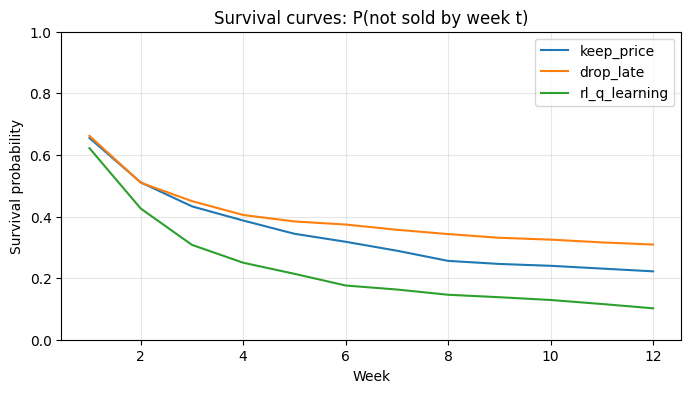

In [ ]:
env_eval = CarPricingEnv(valid_df, empirical_transitions, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=123)

def evaluate_policy(policy_fn, n_eval=N_EVAL):
    returns, weeks, ratio_event = [], [], []
    not_sold_by_week = np.zeros(TMAX + 1)
    for _ in range(n_eval):
        s = env_eval.reset()
        done = False
        total_r = 0.0
        step_count = 0
        last_info = None
        event = False
        while not done and step_count < TMAX:
            a = policy_fn(s, last_info)
            s, r, done, info = env_eval.step(a)
            last_info = info
            total_r += r
            step_count += 1
            event = info["event"]
        returns.append(total_r)
        weeks.append(step_count)
        if event:
            ratio_event.append(np.exp(last_info["delta"]))
        for t in range(1, TMAX + 1):
            if t < step_count or (t == step_count and not event):
                not_sold_by_week[t] += 1
    return {
        "avg_return": float(np.mean(returns)),
        "avg_weeks": float(np.mean(weeks)),
        "avg_price_ratio_cond_event": float(np.mean(ratio_event)) if ratio_event else np.nan,
        "survival": not_sold_by_week / n_eval,
        "returns": np.array(returns),
    }

results = {
    "keep_price": evaluate_policy(baseline_keep_price),
    "rl_q_learning": evaluate_policy(rl_policy),
}
for k, v in results.items():
    print(k, {kk: round(v[kk], 4) for kk in ["avg_return", "avg_weeks", "avg_price_ratio_cond_event"]})

plt.figure(figsize=(8,4))
for k, v in results.items():
    plt.plot(np.arange(1, TMAX + 1), v["survival"][1:], label=k)
plt.title("Survival curves: P(not sold by week t)")
plt.xlabel("Week")
plt.ylabel("Survival probability")
plt.ylim(0,1)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## 8) Online Learning 

In [ ]:
# ── 7.5a  Online Q-Learning Update Function ──────────────────────────────────

def update_q_online(event, alpha=ALPHA*0.05):
    """
    Update Q-table with a single real-world pricing event.
    Use this to adapt the policy as new data arrives.
    
    Parameters:
    -----------
    event : dict
        {
            "seg": str,                    # Segment ID
            "t_week": int,                 # Week when action was taken
            "price_before": float,         # Price before action
            "price_after": float,          # Price after action (or None if unsold)
            "action_taken": int (0-4),     # Index into ACTION_PCTS
            "sold": bool,                  # Did it sell?
            "p0": float,                   # Baseline price
        }
    alpha : float
        Learning rate (lower than offline training for stability)
    
    Returns:
    --------
    td_error : float
        Temporal difference error (monitor convergence)
    """
    # Current state
    seg_id = env_train.seg_to_id.get(event["seg"], 0)
    t = int(event["t_week"])
    delta_t = np.log(event["price_before"] / event["p0"])
    delta_bucket = env_train._delta_bucket(delta_t)
    s = (seg_id, t, delta_bucket)
    
    # Action taken
    a = int(event["action_taken"])
    
    # Reward and next state
    if event["sold"]:
        r = float(event["price_after"])  # Reward = sale price
        s_next = None
        done = True
    else:
        r = -HOLDING_COST  # Cost for holding
        delta_t1 = np.log(event["price_after"] / event["p0"]) if event["price_after"] else delta_t
        delta_bucket_next = env_train._delta_bucket(delta_t1)
        s_next = (seg_id, t + 1, delta_bucket_next)
        done = False
    
    # Q-learning update
    max_q_next = np.max(Q[s_next]) if s_next is not None else 0.0
    old_q = Q[s][a]
    td_target = r + (0.0 if done else GAMMA * max_q_next)
    td_error = td_target - old_q
    Q[s][a] = old_q + alpha * td_error
    
    return float(td_error)

print("✓ update_q_online() ready for real-time policy adaptation")


In [ ]:
# ── 7.5b  Track Online Learning Metrics ──────────────────────────────────────

online_log = {
    "total_updates": 0,
    "td_errors": [],
    "rewards": [],
    "events": [],
}

def log_online_update(event, td_error, reward):
    """
    Record metrics from an online update.
    
    Parameters:
    -----------
    event : dict
        The event that was processed
    td_error : float
        Temporal difference error
    reward : float
        Reward from this step
    """
    online_log["total_updates"] += 1
    online_log["td_errors"].append(td_error)
    online_log["rewards"].append(reward)
    online_log["events"].append(event)
    
    # Keep only recent history for efficiency
    if len(online_log["td_errors"]) > 500:
        online_log["td_errors"] = online_log["td_errors"][-500:]
        online_log["rewards"] = online_log["rewards"][-500:]

def get_online_metrics():
    """Get current online learning metrics."""
    if not online_log["td_errors"]:
        return {}
    return {
        "total_updates": online_log["total_updates"],
        "avg_td_error": float(np.mean(online_log["td_errors"])),
        "avg_reward": float(np.mean(online_log["rewards"])),
        "recent_td_error": float(np.mean(online_log["td_errors"][-10:])),
        "q_table_size": sum(1 for s in Q if np.any(Q[s] != 0)),
    }

print("✓ Online metrics tracking ready")


In [ ]:
# ── 7.5c  Example: Online Update Usage ──────────────────────────────────────

print("\n" + "=" * 80)
print("ONLINE LEARNING EXAMPLE")
print("=" * 80)

# Simulate a real pricing event
example_event = {
    "seg": "VW|Golf|Sedan|2015",
    "t_week": 2,
    "price_before": 12500,
    "price_after": 12700,  # Got sold at higher price!
    "action_taken": 4,     # Raise 5% (index 4 in ACTION_PCTS)
    "sold": True,
    "p0": 12450,
}

print("\nEvent details:")
print(f"  Segment: {example_event['seg']}")
print(f"  Week: {example_event['t_week']}")
print(f"  Action: {ACTION_PCTS[example_event['action_taken']]:+.0%}")
print(f"  Price: €{example_event['price_before']:,.0f} → €{example_event['price_after']:,.0f} (SOLD)")

# Update Q-table with this event
td_error = update_q_online(example_event, alpha=ALPHA*0.05)
reward = example_event["price_after"]
log_online_update(example_event, td_error, reward)

print(f"\nOnline Q-learning update:")
print(f"  TD Error: {td_error:+.2f}")
print(f"  Reward: €{reward:,.0f}")

# Show metrics
metrics = get_online_metrics()
print(f"\nOnline learning metrics:")
for key, val in metrics.items():
    if isinstance(val, float):
        print(f"  {key}: {val:+.2f}" if "error" in key.lower() or "reward" in key.lower() else f"  {key}: {val:.0f}")
    else:
        print(f"  {key}: {val}")

print("\n✓ Policy updated with real event")
print("  Call update_q_online() whenever you get new pricing data")


In [ ]:
# ── 7.5d  Simulate Streaming Real-World Events ──────────────────────────────

print("\n" + "=" * 80)
print("SIMULATING ONLINE LEARNING FROM STREAMING EVENTS")
print("=" * 80)

N_STREAM_EVENTS = 200
env_stream = CarPricingEnv(valid_df, empirical_transitions, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=88)

stream_history = {
    "episode_returns": [],
    "td_errors_episode": [],
    "actions_taken": [],
}

print(f"\nProcessing {N_STREAM_EVENTS} real-world events...\n")

for event_num in range(N_STREAM_EVENTS):
    # Simulate one complete listing lifecycle
    s = env_stream.reset()
    episode_return = 0.0
    episode_td_errors = []
    
    for step in range(TMAX):
        # Agent chooses action
        a = rl_policy(s)
        
        # Get outcome
        s_next, r, done, info = env_stream.step(a)
        episode_return += r
        
        # Create event for online learning
        actual_price = env_stream.p0_value * np.exp(env_stream.delta - np.log1p(ACTION_PCTS[a]))
        price_after = env_stream.p0_value * np.exp(info["delta"]) if info["event"] else actual_price * (1 + np.random.randn()*0.02)
        
        event = {
            "seg": str(env_stream.row["seg"]),
            "t_week": int(s[1]),
            "price_before": actual_price,
            "price_after": price_after,
            "action_taken": int(a),
            "sold": bool(info["event"]),
            "p0": float(env_stream.p0_value),
        }
        
        # Online Q-update
        td_error = update_q_online(event, alpha=ALPHA*0.05)
        log_online_update(event, td_error, r)
        episode_td_errors.append(td_error)
        stream_history["actions_taken"].append(a)
        
        s = s_next
        if done:
            break
    
    stream_history["episode_returns"].append(episode_return)
    if episode_td_errors:
        stream_history["td_errors_episode"].append(np.mean(episode_td_errors))
    
    # Print progress
    if (event_num + 1) % 40 == 0:
        metrics = get_online_metrics()
        avg_return = np.mean(stream_history["episode_returns"][-10:])
        print(f"[Event {event_num + 1:3d}/{N_STREAM_EVENTS}] "
              f"Return: €{avg_return:7.0f} | "
              f"TD Error: {metrics.get('recent_td_error', 0):+.2f} | "
              f"Q-states: {metrics.get('q_table_size', 0):5d}")

print(f"\n{'=' * 80}")
print("STREAMING SIMULATION COMPLETE")
print(f"{'=' * 80}")

final_metrics = get_online_metrics()
print(f"\nFinal metrics after {N_STREAM_EVENTS} events:")
print(f"  Total updates:           {final_metrics.get('total_updates', 0):,}")
print(f"  Avg TD error:            {final_metrics.get('avg_td_error', 0):+.2f}")
print(f"  Avg reward per step:     €{final_metrics.get('avg_reward', 0):,.0f}")
print(f"  Q-table states visited:  {final_metrics.get('q_table_size', 0):,}")


In [ ]:
# ── 7.e  Visualize Online Learning Convergence ──────────────────────────────

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# (a) Episode return trajectory
window = 10
rolling_return = pd.Series(stream_history["episode_returns"]).rolling(window).mean()
axes[0, 0].plot(rolling_return, color="steelblue", linewidth=2, label=f"Rolling avg ({window} events)")
axes[0, 0].scatter(range(len(stream_history["episode_returns"])), 
                   stream_history["episode_returns"], s=10, alpha=0.3, color="gray")
axes[0, 0].set_xlabel("Event #")
axes[0, 0].set_ylabel("Episode Return (€)")
axes[0, 0].set_title("Online Learning: Return Over Time")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# (b) TD Error convergence
rolling_td = pd.Series(online_log["td_errors"]).rolling(window).mean()
axes[0, 1].plot(rolling_td, color="crimson", linewidth=2, label=f"Rolling avg ({window} steps)")
axes[0, 1].scatter(range(len(online_log["td_errors"])), 
                   online_log["td_errors"], s=5, alpha=0.2, color="gray")
axes[0, 1].axhline(0, color="k", linestyle="--", alpha=0.3)
axes[0, 1].set_xlabel("Update #")
axes[0, 1].set_ylabel("TD Error")
axes[0, 1].set_title("TD Error Convergence (Should → 0)")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# (c) Cumulative reward
cumulative_reward = np.cumsum(online_log["rewards"])
axes[1, 0].plot(cumulative_reward, color="darkgreen", linewidth=1.5)
axes[1, 0].fill_between(range(len(cumulative_reward)), cumulative_reward, alpha=0.2, color="green")
axes[1, 0].set_xlabel("Update #")
axes[1, 0].set_ylabel("Cumulative Reward (€)")
axes[1, 0].set_title("Cumulative Reward from Online Updates")
axes[1, 0].grid(alpha=0.3)

# (d) Action distribution
action_dist = np.bincount(stream_history["actions_taken"], minlength=len(ACTION_PCTS))
action_labels = [f"{pct:+.0%}" for pct in ACTION_PCTS]
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(ACTION_PCTS)))
axes[1, 1].bar(action_labels, action_dist, color=colors, edgecolor="black", alpha=0.8)
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Actions Selected During Online Learning")
axes[1, 1].grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print(f"\nAction distribution during online learning:")
for label, count in zip(action_labels, action_dist):
    pct = 100 * count / sum(action_dist)
    print(f"  {label:8s}: {count:5d} times ({pct:5.1f}%)")


## 9) Diagnostics and analysis

### 9.1 — Model Quality Diagnostics

Check the price model's residuals.

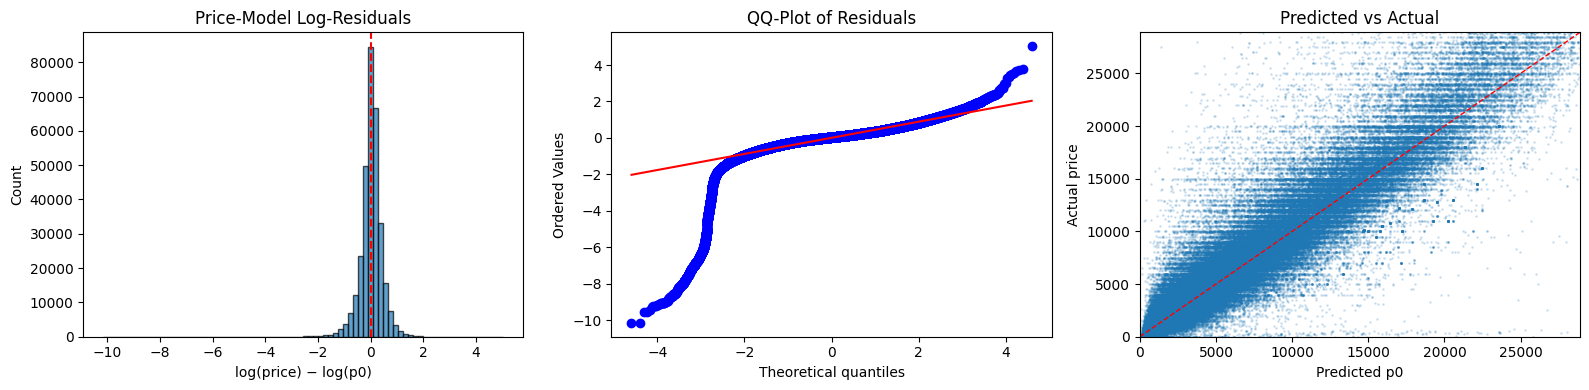

Residual mean: 0.0059,  std: 0.5267
Residual skew: -5.4349,  kurtosis: 70.5438


In [ ]:
# ── 9.1a  Price-model residual analysis ──────────────────────────────────────
pred_log_all = price_model.predict(df[price_num_cols + price_cat_cols])
residuals = np.log(df["price"].values) - pred_log_all

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Histogram of residuals
axes[0].hist(residuals, bins=80, edgecolor="k", alpha=0.7)
axes[0].axvline(0, color="red", ls="--")
axes[0].set_title("Price-Model Log-Residuals")
axes[0].set_xlabel("log(price) − log(p0)")
axes[0].set_ylabel("Count")

# QQ-plot
from scipy import stats
stats.probplot(residuals, plot=axes[1])
axes[1].set_title("QQ-Plot of Residuals")

# Predicted vs Actual
axes[2].scatter(np.exp(pred_log_all), df["price"], s=1, alpha=0.15)
axes[2].plot([0, df["price"].max()], [0, df["price"].max()], "r--", lw=1)
axes[2].set_xlabel("Predicted p0")
axes[2].set_ylabel("Actual price")
axes[2].set_title("Predicted vs Actual")
axes[2].set_xlim(0, df["price"].quantile(0.99))
axes[2].set_ylim(0, df["price"].quantile(0.99))

plt.tight_layout()
plt.show()

print(f"Residual mean: {residuals.mean():.4f},  std: {residuals.std():.4f}")
print(f"Residual skew: {stats.skew(residuals):.4f},  kurtosis: {stats.kurtosis(residuals):.4f}")

### 9.2 — Policy Robustness & Sensitivity
Sweep holding cost and discount factor to see how sensitive the RL policy is versus the baselines.

              keep_price  drop_late  rl_q_learning
holding_cost                                      
5                 4569.8     3786.3         4388.2
10                4548.4     3758.5         4374.9
20                4505.6     3702.8         4348.4
50                4377.2     3535.8         4268.7
100               4163.2     3257.5         4135.8


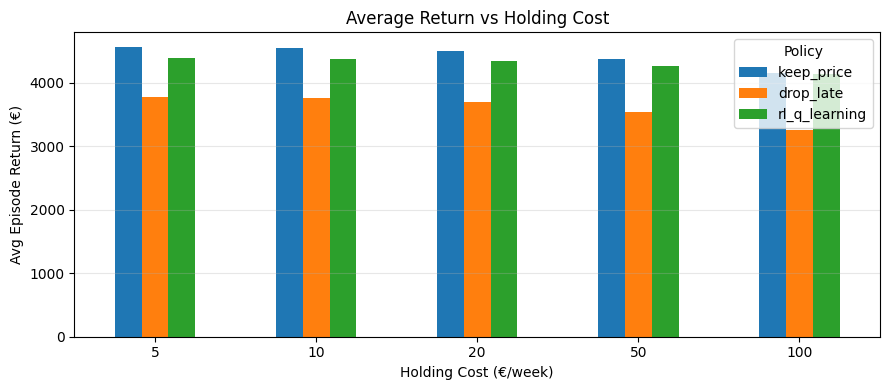

In [ ]:
# ── 9.2  Sensitivity to holding cost ─────────────────────────────────────────
holding_costs_sweep = [5, 10, 20, 50, 100]
sensitivity_rows = []

for hc in holding_costs_sweep:
    env_sweep = CarPricingEnv(
        valid_df, empirical_transitions, delta_bounds, TMAX, ACTION_PCTS, hc, seed=123
    )

    def _eval_sweep(policy_fn, n=300):
        rets = []
        for _ in range(n):
            s = env_sweep.reset()
            done, total_r, steps = False, 0.0, 0
            info = None
            while not done and steps < TMAX:
                a = policy_fn(s, info)
                s, r, done, info = env_sweep.step(a)
                total_r += r
                steps += 1
            rets.append(total_r)
        return float(np.mean(rets))

    sensitivity_rows.append({
        "holding_cost": hc,
        "keep_price": _eval_sweep(baseline_keep_price),
        "rl_q_learning": _eval_sweep(rl_policy),
    })

sens_df = pd.DataFrame(sensitivity_rows).set_index("holding_cost")
print(sens_df.round(1))

sens_df.plot(kind="bar", figsize=(9, 4), rot=0)
plt.title("Average Return vs Holding Cost")
plt.xlabel("Holding Cost (€/week)")
plt.ylabel("Avg Episode Return (€)")
plt.grid(alpha=0.3, axis="y")
plt.legend(title="Policy")
plt.tight_layout()
plt.show()

### 9.3 — Segment-Level Performance Breakdown
Compare average returns per vehicle segment to find where the RL agent outperforms or underperforms baselines.

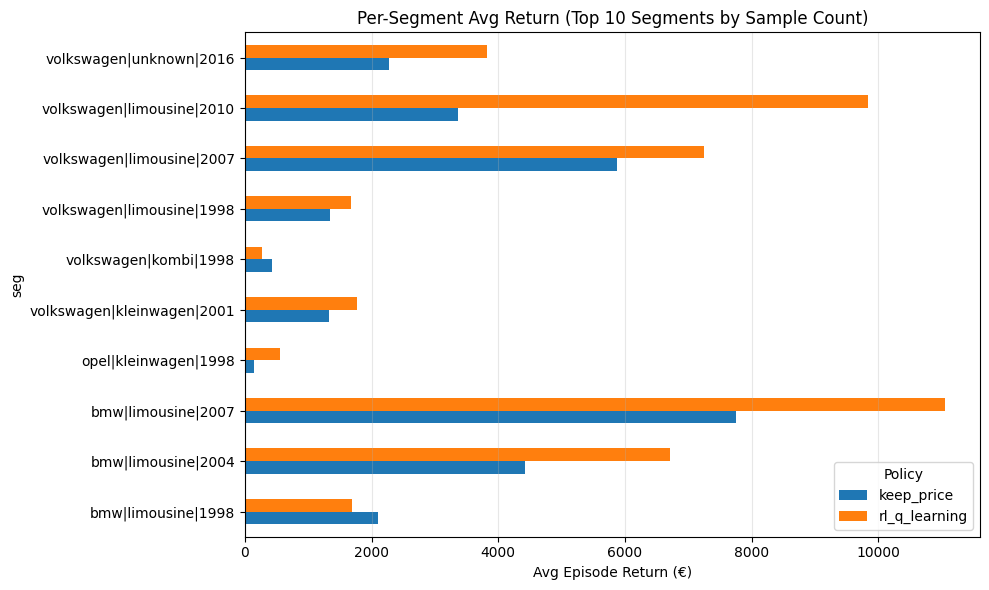


RL advantage over keep_price by segment:
policy                      rl_vs_keep
seg                                   
volkswagen|limousine|2010       6470.9
bmw|limousine|2007              3299.8
bmw|limousine|2004              2290.9
volkswagen|unknown|2016         1537.0
volkswagen|limousine|2007       1372.9
volkswagen|kleinwagen|2001       438.1
opel|kleinwagen|1998             403.3
volkswagen|limousine|1998        330.8
volkswagen|kombi|1998           -150.2
bmw|limousine|1998              -410.6


In [ ]:
# ── 9.3  Segment-level comparison ────────────────────────────────────────────
N_SEG_EVAL = 600

env_seg = CarPricingEnv(valid_df, empirical_transitions, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=77)

seg_records = []
policies = {"keep_price": baseline_keep_price, "rl_q_learning": rl_policy}

for policy_name, policy_fn in policies.items():
    for _ in range(N_SEG_EVAL):
        s = env_seg.reset()
        seg_label = env_seg.row["seg"]
        done, total_r, steps = False, 0.0, 0
        info = None
        while not done and steps < TMAX:
            a = policy_fn(s, info)
            s, r, done, info = env_seg.step(a)
            total_r += r
            steps += 1
        seg_records.append({"policy": policy_name, "seg": seg_label, "return": total_r, "weeks": steps})

seg_perf = pd.DataFrame(seg_records)

# Top 10 most-sampled segments
top_segs = seg_perf["seg"].value_counts().head(10).index
seg_top = seg_perf[seg_perf["seg"].isin(top_segs)]

pivot = seg_top.groupby(["seg", "policy"])["return"].mean().unstack("policy")
pivot = pivot[["keep_price", "rl_q_learning"]]

pivot.plot(kind="barh", figsize=(10, 6))
plt.xlabel("Avg Episode Return (€)")
plt.title("Per-Segment Avg Return (Top 10 Segments by Sample Count)")
plt.grid(alpha=0.3, axis="x")
plt.legend(title="Policy")
plt.tight_layout()
plt.show()

# Show RL advantage / disadvantage
pivot["rl_vs_keep"] = pivot["rl_q_learning"] - pivot["keep_price"]
print("\nRL advantage over keep_price by segment:")
print(pivot[["rl_vs_keep"]].sort_values("rl_vs_keep", ascending=False).round(1))

### 9.4 — Price Action Distribution
Analyse which pricing actions the RL policy selects across the state space, compared to the static baselines.

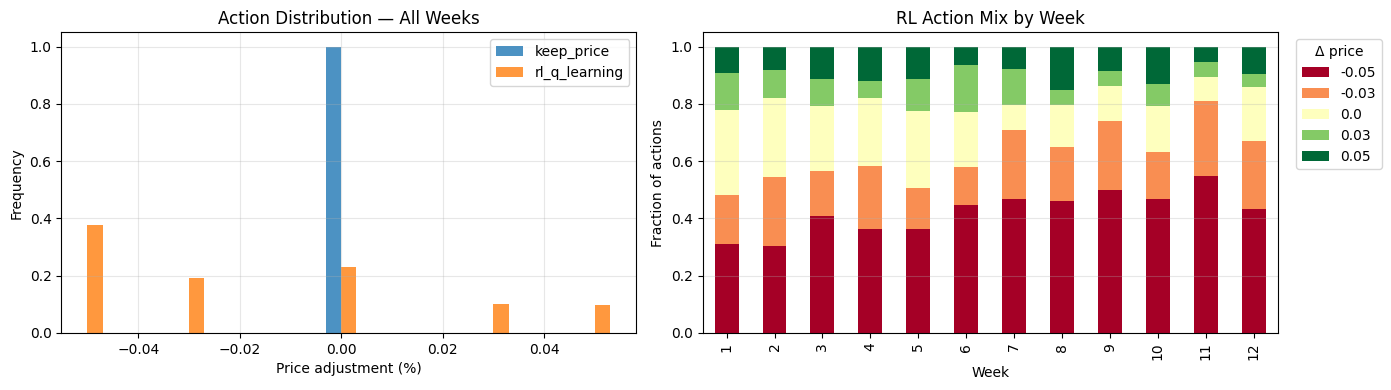


RL action frequency:
action_pct
-0.05    37.8
-0.03    19.3
 0.00    23.1
 0.03    10.1
 0.05     9.7 %


In [ ]:
# ── 9.4  Action distribution of the RL policy ───────────────────────────────
N_ACTION_EVAL = 1000

env_act = CarPricingEnv(valid_df, empirical_transitions, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=99)

action_log = {"policy": [], "action_pct": [], "week": []}

for policy_name, policy_fn in policies.items():
    for _ in range(N_ACTION_EVAL):
        s = env_act.reset()
        done, steps = False, 0
        info = None
        while not done and steps < TMAX:
            a = policy_fn(s, info)
            action_log["policy"].append(policy_name)
            action_log["action_pct"].append(ACTION_PCTS[a])
            action_log["week"].append(s[1])
            s, r, done, info = env_act.step(a)
            steps += 1

act_df = pd.DataFrame(action_log)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Overall action frequency
for pname in ["keep_price", "rl_q_learning"]:
    sub = act_df[act_df["policy"] == pname]
    counts = sub["action_pct"].value_counts().sort_index()
    axes[0].bar(counts.index + {"keep_price": -0.0015, "rl_q_learning": 0.0015}[pname],
                counts.values / counts.values.sum(), width=0.003, label=pname, alpha=0.8)
axes[0].set_xlabel("Price adjustment (%)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Action Distribution — All Weeks")
axes[0].legend()
axes[0].grid(alpha=0.3)

# RL actions by week
rl_acts = act_df[act_df["policy"] == "rl_q_learning"]
week_action = rl_acts.groupby(["week", "action_pct"]).size().unstack(fill_value=0)
week_action_pct = week_action.div(week_action.sum(axis=1), axis=0)
week_action_pct.plot(kind="bar", stacked=True, ax=axes[1], colormap="RdYlGn")
axes[1].set_xlabel("Week")
axes[1].set_ylabel("Fraction of actions")
axes[1].set_title("RL Action Mix by Week")
axes[1].legend(title="Δ price", bbox_to_anchor=(1.02, 1), loc="upper left")
axes[1].grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Summary statistics
print("\nRL action frequency:")
print((rl_acts["action_pct"].value_counts(normalize=True).sort_index() * 100).round(1).to_string() + " %")

### 9.5 — Event Probability vs Realised Sales
Bin predicted event probabilities and compare against the observed sale rate in each bin (reliability diagram on simulation rollouts).

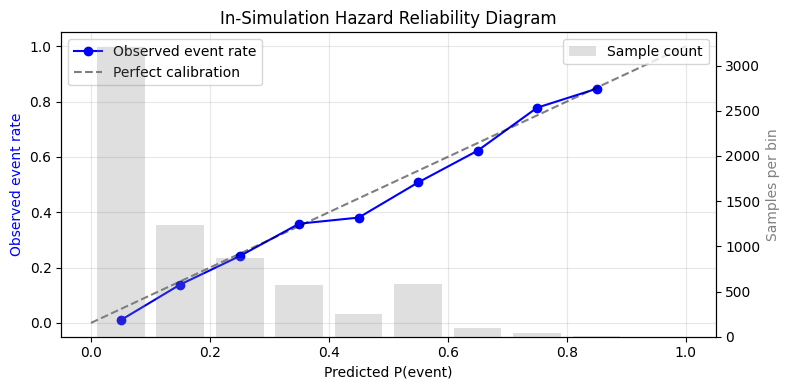

Total step samples: 7,531,  overall event rate: 0.236


In [ ]:
# ── 9.5  In-simulation hazard reliability ─────────────────────────────────────
# Collect (predicted_p, actual_event) pairs during RL policy rollouts
N_RELIABILITY = 2000
env_rel = CarPricingEnv(valid_df, empirical_transitions, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=55)

pred_ps, actual_events = [], []
for _ in range(N_RELIABILITY):
    s = env_rel.reset()
    done, steps = False, 0
    info = None
    while not done and steps < TMAX:
        a = rl_policy(s, info)
        s, r, done, info = env_rel.step(a)
        pred_ps.append(info["p_event"])
        actual_events.append(int(info["event"]))
        steps += 1

pred_ps = np.array(pred_ps)
actual_events = np.array(actual_events)

# Bin into deciles
n_bins_rel = 10
bin_edges = np.linspace(0, 1, n_bins_rel + 1)
bin_centres, obs_rates, bin_counts = [], [], []
for i in range(n_bins_rel):
    mask = (pred_ps >= bin_edges[i]) & (pred_ps < bin_edges[i + 1])
    if mask.sum() > 0:
        bin_centres.append((bin_edges[i] + bin_edges[i + 1]) / 2)
        obs_rates.append(actual_events[mask].mean())
        bin_counts.append(mask.sum())

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(bin_centres, obs_rates, "bo-", label="Observed event rate")
ax1.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Perfect calibration")
ax1.set_xlabel("Predicted P(event)")
ax1.set_ylabel("Observed event rate", color="b")
ax1.set_title("In-Simulation Hazard Reliability Diagram")
ax1.legend(loc="upper left")
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.bar(bin_centres, bin_counts, width=0.08, alpha=0.25, color="gray", label="Sample count")
ax2.set_ylabel("Samples per bin", color="gray")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()
print(f"Total step samples: {len(pred_ps):,},  overall event rate: {actual_events.mean():.3f}")

### 9.6 — Value Function Analysis
Visualise the learned Q-values as a heatmap over (week, delta_bucket) for a representative segment, and inspect the greedy action map.

Most-visited segment id=193  →  bmw|limousine|2001


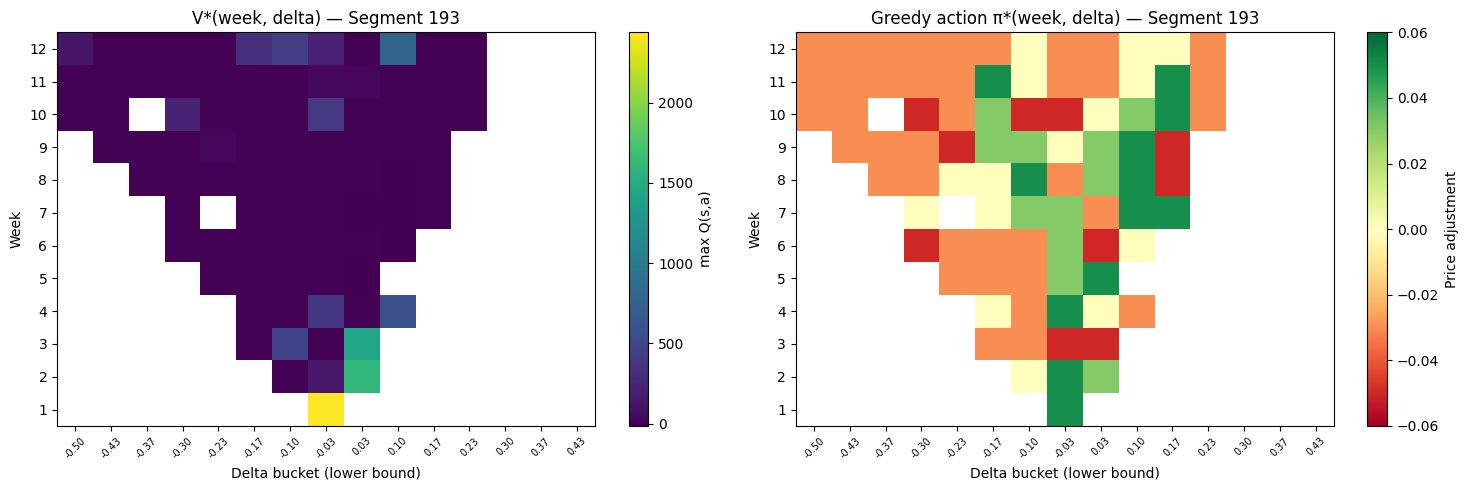


Q-table coverage: 17,171 / 386,640 states visited (4.4%)


In [ ]:
# ── 9.6  Q-value heatmap & greedy action map ─────────────────────────────────
# Find the most-visited segment id
seg_visit_count = defaultdict(int)
for state_key in Q:
    seg_visit_count[state_key[0]] += 1

most_visited_seg_id = max(seg_visit_count, key=seg_visit_count.get)
seg_name = [s for s, i in env_train.seg_to_id.items() if i == most_visited_seg_id]
print(f"Most-visited segment id={most_visited_seg_id}  →  {seg_name[0] if seg_name else '?'}")

n_delta_buckets = len(DELTA_BINS) - 1
weeks_range = np.arange(1, TMAX + 1)

V_grid = np.full((TMAX, n_delta_buckets), np.nan)
A_grid = np.full((TMAX, n_delta_buckets), np.nan)

for t_idx, t in enumerate(weeks_range):
    for db in range(n_delta_buckets):
        state = (most_visited_seg_id, int(t), db)
        if state in Q and np.any(Q[state] != 0):
            V_grid[t_idx, db] = np.max(Q[state])
            A_grid[t_idx, db] = ACTION_PCTS[int(np.argmax(Q[state]))]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Value function heatmap
delta_labels = [f"{DELTA_BINS[i]:.2f}" for i in range(n_delta_buckets)]
im0 = axes[0].imshow(V_grid, aspect="auto", origin="lower", cmap="viridis")
axes[0].set_xticks(range(n_delta_buckets))
axes[0].set_xticklabels(delta_labels, rotation=45, fontsize=7)
axes[0].set_yticks(range(TMAX))
axes[0].set_yticklabels(weeks_range)
axes[0].set_xlabel("Delta bucket (lower bound)")
axes[0].set_ylabel("Week")
axes[0].set_title(f"V*(week, delta) — Segment {most_visited_seg_id}")
plt.colorbar(im0, ax=axes[0], label="max Q(s,a)")

# Greedy action heatmap
im1 = axes[1].imshow(A_grid, aspect="auto", origin="lower", cmap="RdYlGn", vmin=-0.06, vmax=0.06)
axes[1].set_xticks(range(n_delta_buckets))
axes[1].set_xticklabels(delta_labels, rotation=45, fontsize=7)
axes[1].set_yticks(range(TMAX))
axes[1].set_yticklabels(weeks_range)
axes[1].set_xlabel("Delta bucket (lower bound)")
axes[1].set_ylabel("Week")
axes[1].set_title(f"Greedy action π*(week, delta) — Segment {most_visited_seg_id}")
plt.colorbar(im1, ax=axes[1], label="Price adjustment")

plt.tight_layout()
plt.show()

# Count visited vs total states
total_possible = len(env_train.seg_to_id) * TMAX * n_delta_buckets
visited = sum(1 for s in Q if np.any(Q[s] != 0))
print(f"\nQ-table coverage: {visited:,} / {total_possible:,} states visited ({100*visited/total_possible:.1f}%)")

### 9.7 — Out-of-Distribution Detection
Check how often the RL agent visits states during evaluation that were never seen during training.

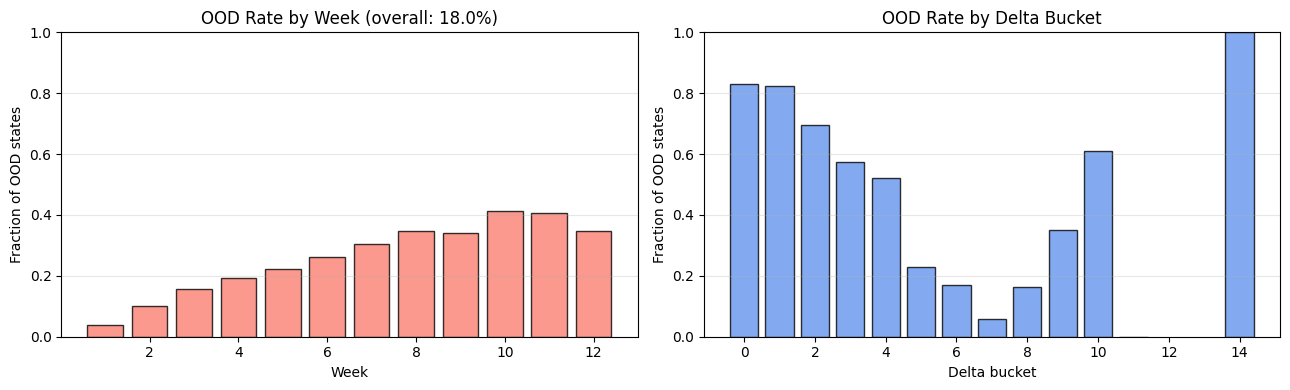

Total eval steps: 3,828
OOD steps:        688  (18.0%)
Trained states:   17,171

Action distribution when OOD:
action
-0.05    100.0 %


In [ ]:
# ── 9.7  Out-of-distribution (OOD) state analysis ────────────────────────────
# States that Q has learned (visited at least once during training)
trained_states = set(s for s in Q if np.any(Q[s] != 0))

N_OOD_EVAL = 1000
env_ood = CarPricingEnv(valid_df, empirical_transitions, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=44)

ood_records = []
for _ in range(N_OOD_EVAL):
    s = env_ood.reset()
    done, steps = False, 0
    info = None
    while not done and steps < TMAX:
        is_ood = s not in trained_states
        a = rl_policy(s, info)
        s_next, r, done, info = env_ood.step(a)
        ood_records.append({"week": s[1], "delta_bucket": s[2], "ood": is_ood, "action": ACTION_PCTS[a]})
        s = s_next
        steps += 1

ood_df = pd.DataFrame(ood_records)
ood_rate = ood_df["ood"].mean()

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# OOD rate by week
ood_by_week = ood_df.groupby("week")["ood"].mean()
axes[0].bar(ood_by_week.index, ood_by_week.values, color="salmon", edgecolor="k", alpha=0.8)
axes[0].set_xlabel("Week")
axes[0].set_ylabel("Fraction of OOD states")
axes[0].set_title(f"OOD Rate by Week (overall: {ood_rate:.1%})")
axes[0].set_ylim(0, 1)
axes[0].grid(alpha=0.3, axis="y")

# OOD rate by delta bucket
ood_by_delta = ood_df.groupby("delta_bucket")["ood"].mean()
axes[1].bar(ood_by_delta.index, ood_by_delta.values, color="cornflowerblue", edgecolor="k", alpha=0.8)
axes[1].set_xlabel("Delta bucket")
axes[1].set_ylabel("Fraction of OOD states")
axes[1].set_title("OOD Rate by Delta Bucket")
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Summary
print(f"Total eval steps: {len(ood_df):,}")
print(f"OOD steps:        {ood_df['ood'].sum():,}  ({ood_rate:.1%})")
print(f"Trained states:   {len(trained_states):,}")
print(f"\nAction distribution when OOD:")
if ood_df["ood"].any():
    print((ood_df[ood_df["ood"]]["action"].value_counts(normalize=True).sort_index() * 100).round(1).to_string() + " %")
else:
    print("  No OOD states encountered — good coverage!")

### 9.8 — Q-learning Convergence & Stability
Analyse the training return curve: rolling statistics, final convergence window, and per-episode return distribution.

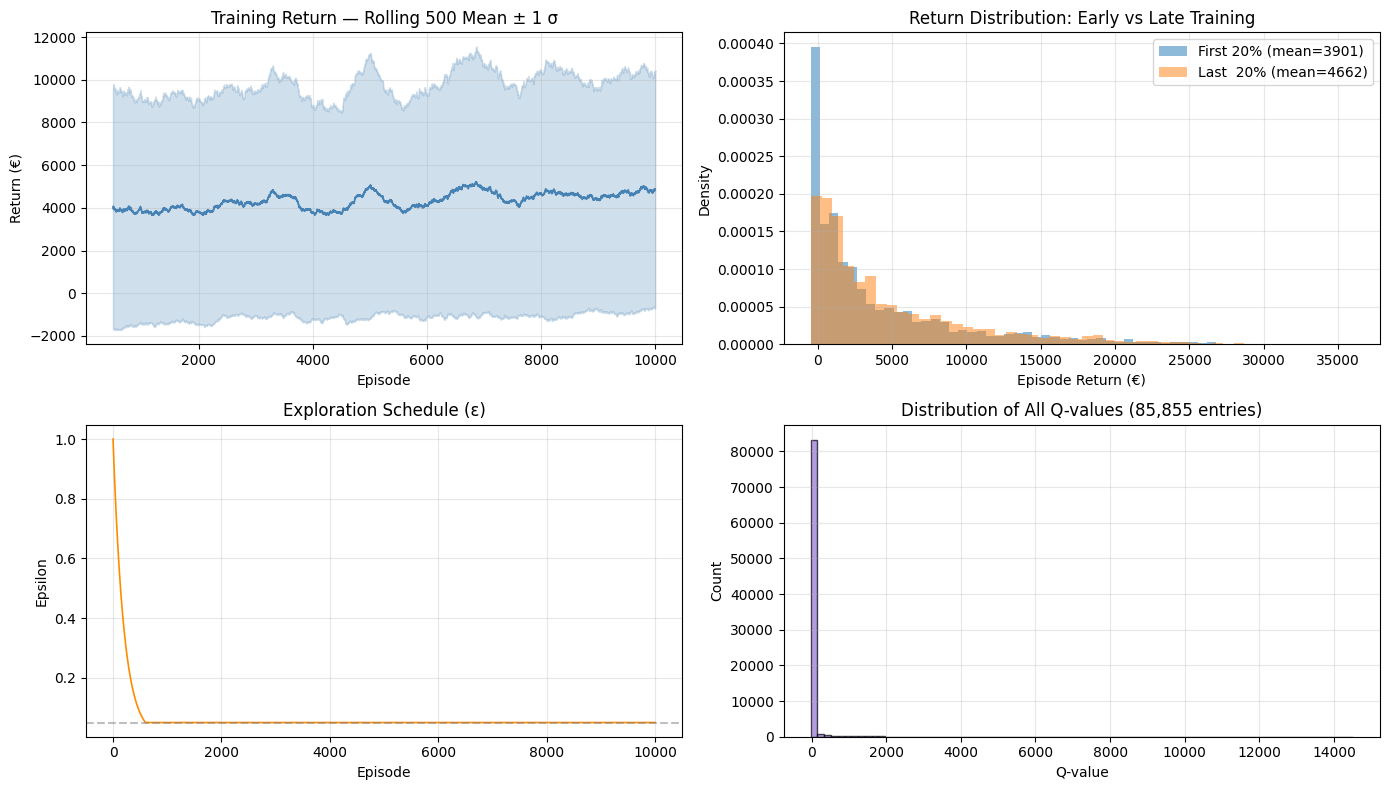

=== Convergence Summary ===
Total episodes:         10,000
Final ε:                0.0500
Last 500 episodes:     mean=4879.0,  std=5549.6
First 500 episodes:    mean=3966.2,  std=5657.0
Improvement:            +912.7 €
Q-table states visited: 17,171
Q-value range:          [-24.6, 14506.6]


In [ ]:
# ── 9.8  Convergence & stability analysis ────────────────────────────────────
returns = np.array(ep_returns)
window = 500

rolling_mean = pd.Series(returns).rolling(window).mean()
rolling_std  = pd.Series(returns).rolling(window).std()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# (a) Rolling mean ± 1 std
ax = axes[0, 0]
ax.fill_between(range(len(returns)),
                (rolling_mean - rolling_std).values,
                (rolling_mean + rolling_std).values,
                alpha=0.25, color="steelblue")
ax.plot(rolling_mean, color="steelblue", lw=1.2)
ax.set_title(f"Training Return — Rolling {window} Mean ± 1 σ")
ax.set_xlabel("Episode")
ax.set_ylabel("Return (€)")
ax.grid(alpha=0.3)

# (b) Histogram of last 20% episodes vs first 20%
n = len(returns)
first_chunk = returns[: n // 5]
last_chunk  = returns[4 * n // 5 :]
ax = axes[0, 1]
ax.hist(first_chunk, bins=50, alpha=0.5, label=f"First 20% (mean={first_chunk.mean():.0f})", density=True)
ax.hist(last_chunk, bins=50, alpha=0.5, label=f"Last  20% (mean={last_chunk.mean():.0f})", density=True)
ax.set_title("Return Distribution: Early vs Late Training")
ax.set_xlabel("Episode Return (€)")
ax.set_ylabel("Density")
ax.legend()
ax.grid(alpha=0.3)

# (c) Epsilon schedule
eps_schedule = [EPS_START * (EPS_DECAY ** i) for i in range(N_EPISODES)]
eps_schedule = np.clip(eps_schedule, EPS_END, EPS_START)
ax = axes[1, 0]
ax.plot(eps_schedule, color="darkorange", lw=1.2)
ax.axhline(EPS_END, ls="--", color="gray", alpha=0.5)
ax.set_title("Exploration Schedule (ε)")
ax.set_xlabel("Episode")
ax.set_ylabel("Epsilon")
ax.grid(alpha=0.3)

# (d) Q-table growth over training
# Approximate: count unique states visited (from ep_returns length proxy)
ax = axes[1, 1]
q_sizes = []
cumulative_states = set()
sample_interval = max(1, N_EPISODES // 200)
# Rebuild approximate growth from Q-table final state
# We show the final Q-table stats instead
q_vals_all = np.concatenate([Q[s] for s in Q if np.any(Q[s] != 0)])
ax.hist(q_vals_all, bins=80, edgecolor="k", alpha=0.7, color="mediumpurple")
ax.set_title(f"Distribution of All Q-values ({len(q_vals_all):,} entries)")
ax.set_xlabel("Q-value")
ax.set_ylabel("Count")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Convergence stats
print("=== Convergence Summary ===")
print(f"Total episodes:         {N_EPISODES:,}")
print(f"Final ε:                {eps_schedule[-1]:.4f}")
print(f"Last {window} episodes:     mean={returns[-window:].mean():.1f},  std={returns[-window:].std():.1f}")
print(f"First {window} episodes:    mean={returns[:window].mean():.1f},  std={returns[:window].std():.1f}")
improvement = returns[-window:].mean() - returns[:window].mean()
print(f"Improvement:            {improvement:+.1f} €")
print(f"Q-table states visited: {sum(1 for s in Q if np.any(Q[s] != 0)):,}")
print(f"Q-value range:          [{q_vals_all.min():.1f}, {q_vals_all.max():.1f}]")

---
## 10) Exploratory Examples

### 10.1 — How are my groups (segments) composed? Show examples


In [ ]:
# ── 10.1  Group composition examples ─────────────────────────────────────────
# Sample a few segments and show their composition
print("=" * 80)
print("SEGMENT COMPOSITION EXAMPLES")
print("=" * 80)

seg_summary = df.groupby("seg").agg({
    "brand": lambda x: x.iloc[0],
    "model_slim": lambda x: x.iloc[0],
    "vehicleType": lambda x: x.iloc[0],
    "year_bin": lambda x: int(x.iloc[0]),
    "price": ["count", "mean", "min", "max"],
    "age_years": "mean",
    "kilometer": "mean",
    "powerPS": "mean"
}).round(0)

seg_summary.columns = ["brand", "model", "vehicleType", "year_bin", "n_listings", "avg_price", "min_price", "max_price", "avg_age", "avg_km", "avg_power"]
seg_summary = seg_summary.sort_values("n_listings", ascending=False)

print(f"\nTop 10 segments by listing count:\n")
print(seg_summary[["brand", "model", "vehicleType", "year_bin", "n_listings", "avg_price"]].head(10).to_string())

# Show a detailed breakdown for one segment
top_seg = seg_summary.index[0]
seg_data = df[df["seg"] == top_seg]

print(f"\n{'-' * 80}")
print(f"DETAILED BREAKDOWN OF TOP SEGMENT: {top_seg}")
print(f"{'-' * 80}")
print(f"\nCharacteristics:")
print(f"  Brand:        {seg_data['brand'].iloc[0]}")
print(f"  Model:        {seg_data['model_slim'].iloc[0]}")
print(f"  Vehicle Type: {seg_data['vehicleType'].iloc[0]}")
print(f"  Year Range:   {seg_data['year_bin'].iloc[0]:.0f}–{seg_data['year_bin'].iloc[0] + 2:.0f}")
print(f"  Count:        {len(seg_data):,} listings")
print(f"\nPrice statistics (€):")
print(f"  Mean:         {seg_data['price'].mean():,.0f}")
print(f"  Median:       {seg_data['price'].median():,.0f}")
print(f"  Std dev:      {seg_data['price'].std():,.0f}")
print(f"  Min / Max:    {seg_data['price'].min():,.0f} / {seg_data['price'].max():,.0f}")
print(f"\nCar characteristics (samples):")
sample_rows = seg_data[[
    "brand", "model", "gearbox", "fuelType", "powerPS", "kilometer", "age_years", "price"
]].head(3).reset_index(drop=True)
print(sample_rows.to_string())

print(f"\nSegment distribution across gearbox/fuel:")
print(seg_data.groupby(["gearbox", "fuelType"]).size().unstack(fill_value=0).to_string())

SEGMENT COMPOSITION EXAMPLES

Top 10 segments by listing count:

                                 brand    model vehicleType  year_bin  n_listings  avg_price
seg                                                                                         
volkswagen|limousine|1998   volkswagen  unknown   limousine      1998        4081     1845.0
volkswagen|kleinwagen|1998  volkswagen     golf  kleinwagen      1998        3889     1295.0
volkswagen|unknown|2016     volkswagen     golf     unknown      2016        3824     3184.0
bmw|limousine|2004                 bmw      3er   limousine      2004        3677     8056.0
volkswagen|kleinwagen|2001  volkswagen     lupo  kleinwagen      2001        3149     2074.0
volkswagen|limousine|2004   volkswagen     golf   limousine      2004        3014     5509.0
volkswagen|kleinwagen|1995  volkswagen     golf  kleinwagen      1995        2989      756.0
bmw|limousine|1998                 bmw      3er   limousine      1998        2862     2721.0
bmw|l

### 10.2 — What are my price predictions? Show examples

In [ ]:
# ── 10.2  Price prediction examples ──────────────────────────────────────────
print("\n" + "=" * 80)
print("PRICE PREDICTION EXAMPLES")
print("=" * 80)

# Sample diverse cars and show predictions
sample_idxs = np.random.choice(len(df), size=min(10, len(df)), replace=False)
sample_df = df.iloc[sample_idxs][["brand", "model", "age_years", "kilometer", "powerPS", "price", "p0"]].copy()
sample_df["delta"] = np.log(sample_df["price"] / sample_df["p0"])
sample_df["error_pct"] = 100 * (sample_df["p0"] - sample_df["price"]) / sample_df["price"]

print("\nSample predictions (10 random cars):\n")
for i, (idx, row) in enumerate(sample_df.iterrows(), 1):
    print(f"{i}. {row['brand']:12s} {row['model']:15s} | age={row['age_years']:3.0f}y | km={row['kilometer']:6.0f} | power={row['powerPS']:3.0f}PS")
    print(f"   Actual price: €{row['price']:8,.0f}  |  Predicted (p0): €{row['p0']:8,.0f}  |  Error: {row['error_pct']:+6.1f}%  |  Delta: {row['delta']:+.2f}")
    print()

# Statistical summary
print(f"{'-' * 80}")
print("Price prediction statistics across all listings:\n")
print(f"  Mean absolute error:  €{(df['price'] - df['p0']).abs().mean():,.0f}")
print(f"  Median absolute error: €{(df['price'] - df['p0']).abs().median():,.0f}")
print(f"  RMSLE (test set):     {rmsle:.4f}")
print(f"  Mean delta (log ratio): {df['delta_obs'].mean():+.4f}")
print(f"  Delta range:          [{df['delta_obs'].min():+.3f}, {df['delta_obs'].max():+.3f}]")

# Show by segment
print(f"\n{'-' * 80}")
print("Prediction accuracy by segment (top 5):\n")
segment_accuracy = df.groupby("seg").apply(
    lambda x: pd.Series({
        "n": len(x),
        "mae": (x["price"] - x["p0"]).abs().mean(),
        "pct_error": 100 * (x["p0"] - x["price"]).abs().mean() / x["price"].mean()
    })
).sort_values("mae", ascending=False).head(5)
print(segment_accuracy.to_string())


PRICE PREDICTION EXAMPLES

Sample predictions (10 random cars):

1. volkswagen   golf            | age= 27y | km=150000 | power=150PS
   Actual price: €   2,950  |  Predicted (p0): €   2,260  |  Error:  -23.4%  |  Delta: +0.27

2. renault      clio            | age=  8y | km=150000 | power= 45PS
   Actual price: €     800  |  Predicted (p0): €     554  |  Error:  -30.8%  |  Delta: +0.37

3. ford         fiesta          | age= 28y | km=125000 | power= 46PS
   Actual price: €     500  |  Predicted (p0): €     552  |  Error:  +10.4%  |  Delta: -0.10

4. seat         mii             | age= 13y | km= 60000 | power= 75PS
   Actual price: €   7,750  |  Predicted (p0): €   6,080  |  Error:  -21.5%  |  Delta: +0.24

5. mercedes_benz m_klasse        | age= 17y | km=150000 | power=224PS
   Actual price: €  20,997  |  Predicted (p0): €  16,442  |  Error:  -21.7%  |  Delta: +0.24

6. audi         a4              | age= 19y | km=150000 | power=163PS
   Actual price: €   8,500  |  Predicted (p0): € 

In [ ]:
# ── 10.2  Price prediction examples ──────────────────────────────────────────
print("\n" + "=" * 80)
print("PRICE PREDICTION EXAMPLES")
print("=" * 80)

# Sample diverse cars and show predictions
sample_idxs = np.random.choice(len(df), size=min(10, len(df)), replace=False)
sample_df = df.iloc[sample_idxs][["brand", "model", "age_years", "kilometer", "powerPS", "price", "p0"]].copy()
sample_df["delta"] = np.log(sample_df["price"] / sample_df["p0"])
sample_df["error_pct"] = 100 * (sample_df["p0"] - sample_df["price"]) / sample_df["price"]

print("\nSample predictions (10 random cars):\n")
for i, (idx, row) in enumerate(sample_df.iterrows(), 1):
    print(f"{i}. {row['brand']:12s} {row['model']:15s} | age={row['age_years']:3.0f}y | km={row['kilometer']:6.0f} | power={row['powerPS']:3.0f}PS")
    print(f"   Actual price: €{row['price']:8,.0f}  |  Predicted (p0): €{row['p0']:8,.0f}  |  Error: {row['error_pct']:+6.1f}%  |  Delta: {row['delta']:+.2f}")
    print()

# Statistical summary
print(f"{'-' * 80}")
print("Price prediction statistics across all listings:\n")
print(f"  Mean absolute error:  €{(df['price'] - df['p0']).abs().mean():,.0f}")
print(f"  Median absolute error: €{(df['price'] - df['p0']).abs().median():,.0f}")
print(f"  RMSLE (test set):     {rmsle:.4f}")
print(f"  Mean delta (log ratio): {df['delta_obs'].mean():+.4f}")
print(f"  Delta range:          [{df['delta_obs'].min():+.3f}, {df['delta_obs'].max():+.3f}]")

# Show by segment
print(f"\n{'-' * 80}")
print("Prediction accuracy by segment (top 5):\n")
segment_accuracy = df.groupby("seg").apply(
    lambda x: pd.Series({
        "n": len(x),
        "mae": (x["price"] - x["p0"]).abs().mean(),
        "pct_error": 100 * (x["p0"] - x["price"]).abs().mean() / x["price"].mean()
    })
).sort_values("mae", ascending=False).head(5)
print(segment_accuracy.to_string())


PRICE PREDICTION EXAMPLES

Sample predictions (10 random cars):

1. volkswagen   golf            | age= 27y | km=150000 | power=150PS
   Actual price: €   2,950  |  Predicted (p0): €   2,260  |  Error:  -23.4%  |  Delta: +0.27

2. renault      clio            | age=  8y | km=150000 | power= 45PS
   Actual price: €     800  |  Predicted (p0): €     554  |  Error:  -30.8%  |  Delta: +0.37

3. ford         fiesta          | age= 28y | km=125000 | power= 46PS
   Actual price: €     500  |  Predicted (p0): €     552  |  Error:  +10.4%  |  Delta: -0.10

4. seat         mii             | age= 13y | km= 60000 | power= 75PS
   Actual price: €   7,750  |  Predicted (p0): €   6,080  |  Error:  -21.5%  |  Delta: +0.24

5. mercedes_benz m_klasse        | age= 17y | km=150000 | power=224PS
   Actual price: €  20,997  |  Predicted (p0): €  16,442  |  Error:  -21.7%  |  Delta: +0.24

6. audi         a4              | age= 19y | km=150000 | power=163PS
   Actual price: €   8,500  |  Predicted (p0): € 

### 10.3 — What are my agent's policies? Show examples

In [ ]:
# ── 10.4  Agent policy examples ──────────────────────────────────────────────
print("\n" + "=" * 80)
print("AGENT POLICY EXAMPLES — SAME CAR, DIFFERENT POLICIES")
print("=" * 80)

# Simulate a few episodes with all policies on the SAME cars for comparison
N_DEMO = 3
env_demo = CarPricingEnv(valid_df, empirical_transitions, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=111)

policies_demo = {
    "keep_price": baseline_keep_price,
    "rl_q_learning": rl_policy
}

# Sample N_DEMO cars once
demo_cars = []
for _ in range(N_DEMO):
    env_demo.reset()
    demo_cars.append(env_demo.row.copy())

# Now evaluate each policy on the SAME N_DEMO cars
for ep_num in range(N_DEMO):
    car_info = demo_cars[ep_num]
    
    print(f"\n{'=' * 80}")
    print(f"SCENARIO {ep_num + 1}: {car_info['brand']} {car_info['model']} ({car_info['vehicleType']}, {car_info['age_years']:.0f}y old)")
    print(f"Baseline price (p0): €{car_info['p0']:,.0f}")
    print(f"{'=' * 80}\n")
    
    # Evaluate each policy on this SAME car
    for policy_name, policy_fn in policies_demo.items():
        print(f"\n{policy_name.upper()}:")
        print(f"  Week | Δ(t) | Action      | Event prob | Event? | Reward      | Cumulative")
        print(f"  {'-' * 85}")
        
        # Manually simulate from this car state
        s = (env_demo.seg_to_id.get(car_info["seg"], 0), 1, env_demo._delta_bucket(0.0))
        t = 1
        delta = 0.0
        p0_val = car_info["p0"]
        total_r = 0.0
        done = False
        step = 0
        info = None
        
        while not done and step < TMAX:
            a = policy_fn(s, info)
            action_pct = ACTION_PCTS[a]
            action_bins = ["drop_5%", "drop_3%", "hold", "raise_3%", "raise_5%"]
            action_bin = action_bins[a]
            
            # Lookup empirical transition
            trans_match = empirical_transitions[
                (empirical_transitions["seg"] == str(car_info["seg"])) &
                (empirical_transitions["t_week"] == int(t)) &
                (empirical_transitions["action_bin"] == action_bin)
            ]
            
            if len(trans_match) > 0:
                p_event = float(trans_match.iloc[0]["p_sale"])
            else:
                seg_action_avg = empirical_transitions[
                    (empirical_transitions["seg"] == str(car_info["seg"])) &
                    (empirical_transitions["action_bin"] == action_bin)
                ]
                if len(seg_action_avg) > 0:
                    p_event = float(seg_action_avg["p_sale"].mean())
                else:
                    p_event = float(empirical_transitions[
                        empirical_transitions["action_bin"] == action_bin
                    ]["p_sale"].mean())
            
            # Sample event
            delta_new = delta + np.log1p(action_pct)
            dmin, dmax = delta_bounds.get(str(car_info["seg"]), (-0.5, 0.5))
            delta_new = float(np.clip(delta_new, dmin, dmax))
            
            event = np.random.random() < p_event
            
            if event:
                actual_price = p0_val * np.exp(delta_new)
                r = float(actual_price)
                done = True
            else:
                r = -HOLDING_COST
                t += 1
                done = t > TMAX
            
            total_r += r
            event_str = "✓ SOLD" if event else "—"
            price_str = f"€{p0_val * np.exp(delta_new):,.0f}" if event else "—"
            
            print(f"  {s[1]:4.0f} | {delta_new:+.2f} | {action_pct:+.1%} ({action_bin:8s}) | {p_event:6.1%}   | {event_str:6s} | {price_str:12s} | €{total_r:,.0f}")
            
            # Update state for next step
            delta = delta_new
            s = (s[0], int(t), env_demo._delta_bucket(delta))
            step += 1
        
        print(f"  {'-' * 85}")
        print(f"  TOTAL RETURN: €{total_r:,.0f} (weeks: {step}, final price ratio: {np.exp(delta):+.2%})")

# Summary table of policy comparison
print(f"\n{'=' * 80}")
print("OVERALL POLICY COMPARISON (from full evaluation)")
print(f"{'=' * 80}\n")
comparison_df = pd.DataFrame([
    {"Policy": k, "Avg Return": f"€{v['avg_return']:,.0f}", "Avg Weeks": f"{v['avg_weeks']:.1f}", "Price Ratio (on sale)": f"{v['avg_price_ratio_cond_event']:+.1%}"}
    for k, v in results.items()
])
print(comparison_df.to_string(index=False))


AGENT POLICY EXAMPLES — SAME CAR, DIFFERENT POLICIES

SCENARIO 1: suzuki jimny (cabrio, 25y old)
Baseline price (p0): €1,989


KEEP_PRICE:
  Week | Δ(t) | Action      | Event prob | Event? | Reward      | Cumulative
  -------------------------------------------------------------------------------------
     1 | +0.36 | +0.0% (hold    ) |  12.1%   | —      | —            | €-40
     2 | +0.36 | +0.0% (hold    ) |  12.1%   | —      | —            | €-80
     3 | +0.36 | +0.0% (hold    ) |  12.1%   | —      | —            | €-120
     4 | +0.36 | +0.0% (hold    ) |  12.1%   | —      | —            | €-160
     5 | +0.36 | +0.0% (hold    ) |  12.1%   | —      | —            | €-200
     6 | +0.36 | +0.0% (hold    ) |  12.1%   | —      | —            | €-240
     7 | +0.36 | +0.0% (hold    ) |  12.1%   | —      | —            | €-280
     8 | +0.36 | +0.0% (hold    ) |  12.1%   | —      | —            | €-320
     9 | +0.36 | +0.0% (hold    ) |  12.1%   | —      | —            | €-360
    